# ACCESS-OM2 1$^\circ$

This notebook documents our first attempt to run and analyse output from the ACCESS-OM2 Pre-release, implemented at 1°.


## Current Status


|** Run Name** | **Forcing** | ** Run ** | ** Status **|
|--------------|---------|-------------------------------------------------|-------------|
|1deg_jra55_ryf_spinup1 | JRA55 RYF9091| A short 10 year spinup with first pre-release code. Had bugs in runoff and salt fluxes.| Aborted after 10 years.| 
|1deg_jra55_ryf_spinup2 | JRA55 RYF9091| Second attempt at 1° test. There are significant problems with salt and mass conservation in this run.| Stopped at 100 years.| 
|1deg_jra55_ryf_spinup3 | JRA55 RYF9091| Nic's initial 1° test. Still problems with salinity. Also, much of this run has problems with the ocean.nc files. | Stopped at 80 years.| 
|1deg_jra55_ryf_spinup4 | JRA55 RYF9091| Nic's improved 1° test. This simulation seems to have fixed the salt and volume imbalance, but is missing some diagnostics.| Up to 25 years.| 
|1deg_jra55_ryf_spinup5 | JRA55 RYF9091| Andy's 1° test. Unfortunately, this run reverted to the old ice_salt_concentration = 0.004 namelist setting, so melt and salt are unbalanced. | Stopped at year 40.| 
|1deg_jra55_ryf_spinup6 | JRA55 RYF9091| Andy's New & Improved 1° test. Again, this has a salt imbalance | Stopped after 24 years.| 
|1deg_jra55_ryf_spinup7 | JRA55 RYF9091| Same as spinup6, but with the Red Sea fix switched off. | Stopped after 28 years.| 
|1deg_jra55_ryf_spinup8 | JRA55 RYF9091| Same as spinup7, but update to Nic's new executable where we **think** the melt flux is now handled correctly. Turned Red Sea fix back on after year 4. This is running smoothly, but I can't get the timestep beyond 2160 (we are hoping for 3600).  | Stopped at year 184.| 
|1deg_jra55_ryf_spinup9 | JRA55 RYF9091| Same as spinup8 but with massless ice (max_ice_thickness=0.0). We are hoping this will improve model stability.  | 2 years in| 


### Notes


**Last updated 8 September 2017**

In [ ]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

In [ ]:
cc.build_index()

Searching /g/data3/hh5/tmp/cosima/


## Experiments

In [ ]:
configuration = 'access-om2'
expts = cc.get_experiments(configuration)

configuration = 'mom-sis'
expts.extend(cc.get_experiments(configuration))
display(expts)

In [ ]:
# This subset of cases are the important ones
esub = ['1deg_jra55_ryf_spinup8',
 '1deg_jra55_ryf8485_spinup2',
 'mom-sis_jra-ryf',
 'mom-sis_core-nyf']

## Wind Stress
Just a simple plot showing zonally averaged zonal wind stress from each case.

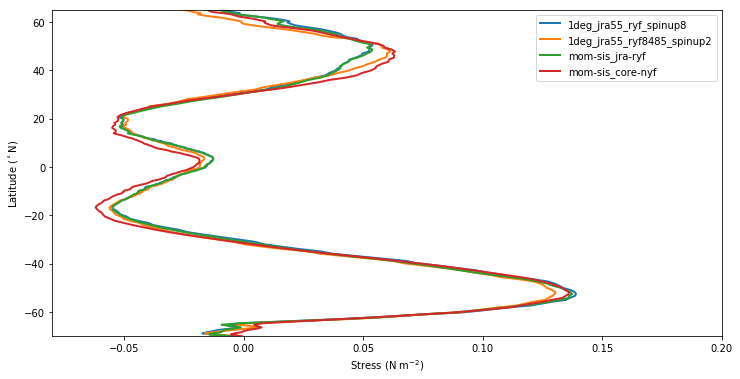

In [14]:
cc.plots.wind_stress(esub)

## Ocean Scalars
The following series of plots shows global timeseries of key metrics.

In [ ]:
# If you want to clear stuff
# cc.diagnostics.annual_scalar.clear()

Calculating...done.


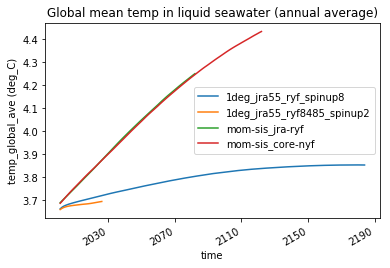

In [15]:
cc.plots.annual_scalar(esub, 'temp_global_ave')

Calculating...done.


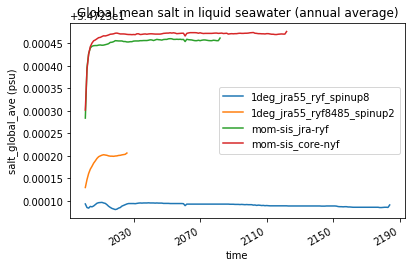

In [16]:
cc.plots.annual_scalar(esub, 'salt_global_ave')

Calculating...done.


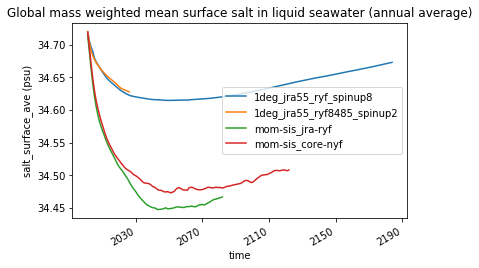

In [17]:
cc.plots.annual_scalar(esub, 'salt_surface_ave')

Calculating...done.


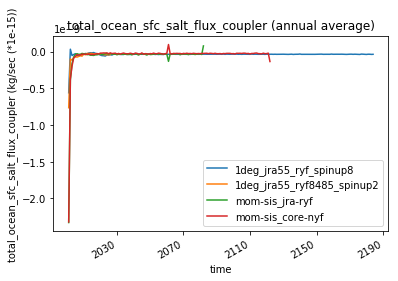

In [18]:
cc.plots.annual_scalar(esub, 'total_ocean_sfc_salt_flux_coupler')

Calculating...done.


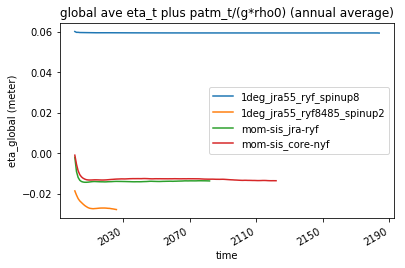

In [19]:
cc.plots.annual_scalar(esub, 'eta_global')

In [20]:
variables = cc.netcdf_index.get_scalar_variables(configuration)

In [21]:
from ipywidgets import widgets, interact, interactive, fixed
interactive(cc.plots.annual_scalar,
            expts=fixed(esub),
            variable=widgets.Dropdown(options=variables, description='Scalar Variable:'))

A Jupyter Widget

# Drake Passage Transport

{'xloc': 210, 'ymin': 21, 'ymax': 54}


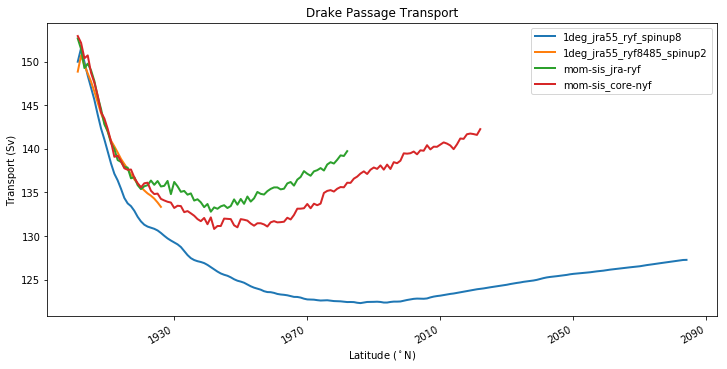

In [22]:
plt.figure(figsize=(12,6))
StraightDicts = { 'DrakePassage' :  {'xloc':210,'ymin':21,'ymax':54},}
TransDict = StraightDicts['DrakePassage']
print(TransDict)
for e in esub:
    tx = cc.get_nc_variable(e,'ocean_month.nc','tx_trans_int_z',chunks={'yt_ocean':200},
                         time_units = 'days since 1900-01-01').isel(xu_ocean=TransDict['xloc'])
    tx_trans = tx[:,TransDict['ymin']:TransDict['ymax']]
    if tx_trans.units == 'Sv (10^9 kg/s)':
        transport = tx_trans.sum('yt_ocean')
    else:
        print('WARNING: Changing units for ', e)
        transport = tx_trans.sum('yt_ocean')*1.0e-9
    transport.resample('A','time').plot(label=e, linewidth=2)


plt.xlabel('Latitude ($^\circ$N)')
plt.title('Drake Passage Transport')
plt.ylabel('Transport (Sv)')
plt.legend(loc='upper right',fontsize=10)


In [ ]:
xu_ocean = cc.get_nc_variable(e,'ocean_month.nc','xu_ocean')
print xu_ocean(TransDict[210-2:210+2])

# Meridional Overturning Circulation

In [23]:
def calc_psi_avg(expt):
    print('Calculating {} psi_avg'.format(expt))
    
    #op = lambda p: p.sum('grid_xt_ocean').cumsum('potrho')

    psi = cc.get_nc_variable(expt, 'ocean.nc', 'ty_trans_rho',
                        chunks={'potrho': None}, time_units = 'days since 1900-01-01', n=10)
    
    if psi.units == 'kg/s':
        print('WARNING: Changing units for ', expt)
        psi = psi*1.0e-9
        
    psi2 = cc.get_nc_variable(expt, 'ocean.nc', 'ty_trans_rho_gm',
                       chunks={'potrho': None}, time_units = 'days since 1900-01-01', n=10)
    
    if psi2.units == 'kg/s':
        print('WARNING: Changing units for ', expt)
        psi2 = psi2*1.0e-9
    
    psi = psi# + psi2    
    
    psi_avg = psi.sum('grid_xt_ocean').cumsum('potrho').mean('time') - psi.sum('grid_xt_ocean').sum('potrho').mean('time')
    psi2_avg = psi2.sum('grid_xt_ocean').mean('time')
    psi_avg = psi_avg.compute() + psi2_avg.compute()
    
    
    return psi_avg

In [24]:
def plot_psi(psi_avg, expt, clev=np.arange(-20,20,2)):

    plt.contourf(psi_avg.grid_yu_ocean, 
                 psi_avg.potrho, 
                 psi_avg, 
                 cmap=plt.cm.PiYG,levels=clev,extend='both')
    cb=plt.colorbar(orientation='vertical', shrink = 0.7)
    cb.ax.set_xlabel('Sv')
    plt.contour(psi_avg.grid_yu_ocean, 
                psi_avg.potrho, 
                psi_avg, levels=clev, colors='k', linewidths=0.25)
    plt.contour(psi_avg.grid_yu_ocean,
                psi_avg.potrho, psi_avg,
                levels=[0.0,], colors='k', linewidths=0.5)
    plt.gca().invert_yaxis()
    
    plt.ylim((1037.5,1034))
    plt.ylabel('Potential Density (kg m$^{-3}$)')
    plt.xlabel('Latitude ($^\circ$N)')
    plt.xlim([-75,85])
    plt.title('Overturning in %s' % expt)

Calculating 1deg_jra55_ryf_spinup8 psi_avg
Calculating 1deg_jra55_ryf8485_spinup2 psi_avg


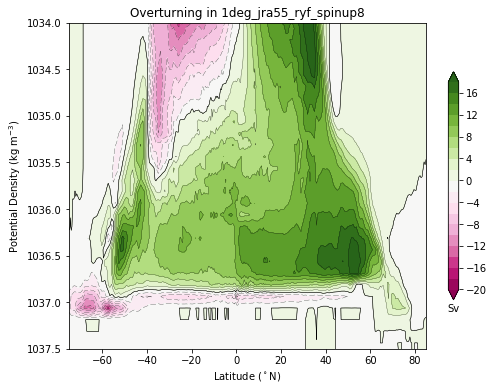

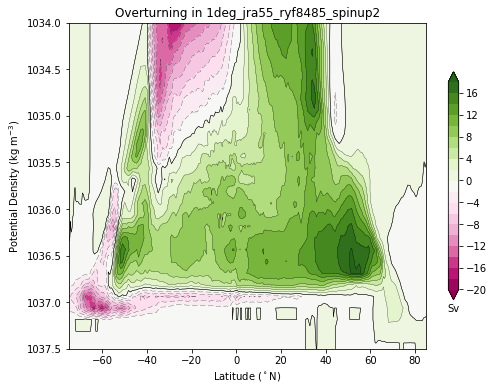

In [25]:
for e in esub[0:2]: 
    plt.figure(figsize=(8, 6)) 
    psi_avg = calc_psi_avg(e)
    plot_psi(psi_avg, e)